# Overview

Genarate semi-synthetic TCSPC-FLIM data based using the HPA fluorescence image database
- Load the cropped HPA images
- Load the dictionary containing the IRFs and laser jittering range
- Define laser frequency and number of time bins

In [1]:
import os
import numpy as np
import torch
import h5py
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import convolve
from scipy.stats import poisson

from utils_simulation import getPerlin, tau_channel, calculate_ratio

In [2]:
# data directories
img_dir = 'data/cropped_imgs' # dir of intensity image
imgs_ls = os.listdir(img_dir) # list of image names
save_dir = 'data/FLIM_synthetic' # dir to save simulated FLIM images

# parameters
nTG = 256 # number of time bins
freq = 40*1e6 # instrument freq. in Hz
dim = [256, 256] # image dimentions

# get time resolution in nanoseconds
time_resolution = 1 / (freq * 256) * 1e9  # ns
time = (torch.arange(0, 256) * time_resolution)[:nTG] # time axis for fluorescence lifetime simulation

In [3]:
time_resolution

0.09765625

In [3]:
# load irfs from .h5 file
with h5py.File('data/irf_library.h5', 'r') as file:
    irf_dict = {k: file['dict_irfs'][k][:] for k in file['dict_irfs']}

## Lifetime simulation

In [4]:
def gen_lifetime_maps(img, data_dir, save_dir, time, normalise=True,
                      save=False, photon_range_min=[10, 60], photon_range_max=[20, 40]):
    """
    FLIM image simulation

    img: the image file name
    data_dir: the directory where raw image data is stored
    save_dir: the directory where results will be saved
    time: time axis in nanoseconds
    normalise: whether to normalise decay curves between 0 and 1
    save: whether to save the output
    photon_range_min: minimum photon range [low, high].
    photon_range_max: maximum photon count variation range [low, high].
    """

    # load raw intensity image file
    with h5py.File(os.path.join(data_dir, img), 'r') as hf:
        raw_img = torch.tensor(hf['raw_intensity'][:])

    # randomly select an irf
    irf_int = random.randrange(len(irf_dict['irf_id']))
    irf = torch.tensor(irf_dict['irf'][irf_int])
    # get associated laser jitter range
    laser_jitter = torch.tensor(irf_dict['laser_jitter'][irf_int])

    # generate a random value for determining laser jitter effects
    r = np.random.random()
    # add laser jitter effects
    if r <= 0.5:
        # shift irf peak towards shorter lifetimes
        shift = np.random.randint(0, laser_jitter[0])
        irf_lj = torch.cat((irf[1 + shift:nTG], torch.zeros(1 + shift)))
    else:
        # shift irf peak towards longer lifetimes
        shift = np.random.randint(0, laser_jitter[1])
        irf_lj = torch.cat((torch.zeros(shift), irf[:nTG - shift]))

    # randomly select minimum and maximum photon counts for non-background pixels
    min_photons = int(np.random.uniform(photon_range_min[0], photon_range_min[1]))
    max_photons = int(min_photons + np.random.uniform(photon_range_max[0], photon_range_max[1]))

    # create a mask for non-background pixels
    mask = raw_img.sum(-1) != 0
    # initialise intensity image
    inten_img = torch.zeros_like(raw_img.sum(-1), dtype=torch.float32)

    # normalise raw intensity image to [0, 1]
    normalised_intensity = (raw_img.sum(-1) - raw_img.sum(-1).min()) / (raw_img.sum(-1).max() - raw_img.sum(-1).min())
    # scale normalised intensity to photon range
    scaled_values = (normalised_intensity * (max_photons - min_photons) + min_photons).round().to(torch.int)
    # mask out background pixels
    inten_img = inten_img.to(torch.int)
    inten_img[mask] = scaled_values[mask]

    # generate random lifetime values for each colour channel
    # tau_range is the base fluorescence lifetime value for this channel and tau_range is the variation in fluorescence lifetime values
    micro_tau = tau_channel(img = raw_img[:, :, 0], dim = [inten_img.shape[0], inten_img.shape[1]], tau_range = [0.1, 10.0], tau_dist = [0.2, 2])  # microtubules
    prot_tau = tau_channel(img = raw_img[:, :, 1], dim = [inten_img.shape[0], inten_img.shape[1]], tau_range = [0.1, 10.0], tau_dist = [0.2, 2])  # proteins
    nucleus_tau = tau_channel(img = raw_img[:, :, 2], dim = [inten_img.shape[0], inten_img.shape[1]], tau_range = [0.1, 10.0], tau_dist = [0.2, 2])  # nucleus
    er_tau = tau_channel(img = raw_img[:, :, 3], dim = [inten_img.shape[0], inten_img.shape[1]], tau_range = [0.1, 10.0], tau_dist = [0.2, 2])  # endoplasmic reticulum

    # initialise fluorescence lifetime map and ground truth map
    tau_image = torch.zeros((nTG, inten_img.shape[0], inten_img.shape[1]), dtype=torch.float32)
    ground_truth_tau = torch.zeros((inten_img.shape[0], inten_img.shape[1]), dtype=torch.float32)

    # generate perlin noise to determine colour channel contribution
    octaves = torch.randint(3, 6, (1,)).item()
    persistence = torch.tensor(np.random.uniform(0.3, 0.9)).item()
    perlin = getPerlin(X=inten_img.shape[0], Y=inten_img.shape[1], octaves=octaves, persistence=persistence)

    # iterate through each pixel to calculate decay curves
    for x in range(inten_img.shape[0]):
        for y in range(inten_img.shape[1]):
            # extract lifetime values for the pixel
            tau_values = torch.tensor([micro_tau[x, y], prot_tau[x, y], nucleus_tau[x, y], er_tau[x, y]])
            tau_values = tau_values[tau_values != 0]

            if inten_img[x, y] == 0:
                # assign zero decay for background pixels
                tau_image[:, x, y] = torch.zeros(nTG, dtype=torch.float32)
            else:
                # calculate contribution ratio for each colour channel and simulate decay curve
                components = tau_values.size(0)
                ratios = torch.tensor(calculate_ratio(perlin[x, y], components), dtype=torch.float32)
                decay_curve = torch.sum(ratios.unsqueeze(1) * torch.exp(-time / tau_values.unsqueeze(1)), dim=0)

                # store average fluorescence lifetime
                ground_truth_tau[x, y] = torch.sum(ratios.unsqueeze(1) * tau_values.unsqueeze(1), dim=0)

                # convolve decay curve with irf
                decay_conv = convolve(decay_curve.numpy(), irf_lj, mode='full')[:nTG]
                decay_conv = torch.tensor(decay_conv, dtype=torch.float32)

                # scale decay curve with photon counts and add poisson noise
                decay_conv *= inten_img[x, y] / torch.sum(decay_conv)
                decay_noisy = torch.poisson(decay_conv.clone().detach()).to(torch.float32)

                # assign normalised or unnormalised decay curve
                tau_image[:, x, y] = decay_noisy / decay_noisy.max() if normalise else decay_noisy

    if save:
        # save data if save is true
        os.makedirs(save_dir, exist_ok=True)
        with h5py.File(os.path.join(save_dir, str(img)), 'w') as hf:
            hf.create_dataset('tau_map', data=tau_image)
            hf.create_dataset('ground_truth', data=ground_truth_tau)

    return tau_image.float().numpy(), irf_lj.numpy(), ground_truth_tau.numpy()

**Parameters**
- **low photon counts** (10 - 100 per pixel) : photon_range_min =[10, 60], photon_range_max = [10, 40]
- **high photon counts** (100 - 2500 per pixel) : photon_range_min =[100, 2000], photon_range_max = [100, 500]

In [6]:
photon_condition = "high"  # Select between "high" (100-2500 photons) and "low" (10-100 photons)

# Define photon ranges for each condition
photon_ranges = {
    "high": {"min": [100, 2000], "max": [100, 500]},
    "low": {"min": [10, 60], "max": [10, 40]},
}

if photon_condition not in photon_ranges:
    raise ValueError("Invalid photon_condition! Please set it to either 'high' or 'low'.")

# Process images
for img in tqdm(imgs_ls, desc="Processing Images", unit="image"):
    ranges = photon_ranges[photon_condition]
    out = gen_lifetime_maps(
        img=img,
        data_dir=img_dir,
        save_dir=save_dir,
        time=time,
        normalise=True,
        save=True,
        photon_range_min=ranges["min"],
        photon_range_max=ranges["max"]
    )


Processing Images: 100%|██████████| 8/8 [09:04<00:00, 68.05s/image]


## Plot example image

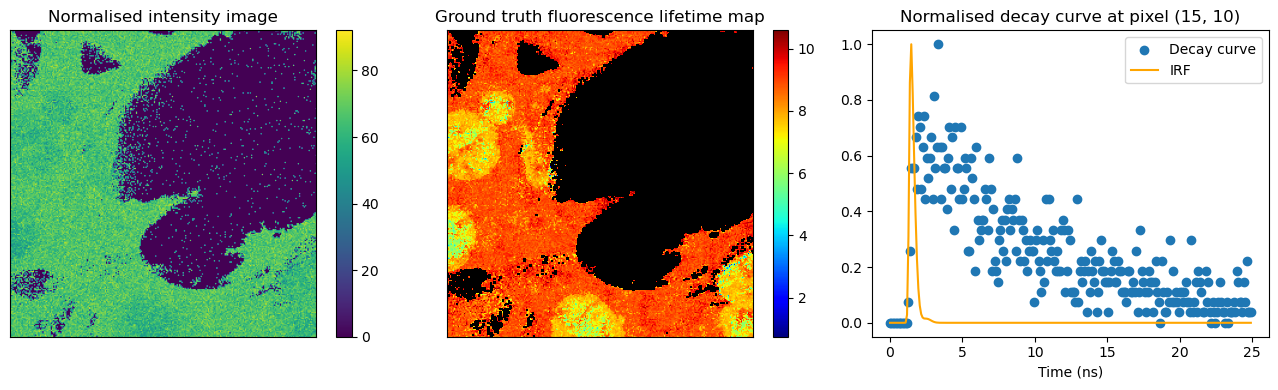

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

raw_flim, irf, gt = out # Get raw simulated FLIM image (t, x, y), IRF and ground truth lifetime map  

# Display the normalised simulated FLIM image
# Sum time channel to show intentsity image
int_img = axes[0].imshow(raw_flim.sum(0),)  
# Add a color bar
plt.colorbar(int_img, ax=axes[0], orientation='vertical', )
axes[0].set_title("Normalised intensity image")
# Remove axes
axes[0].set_xticks([])
axes[0].set_yticks([]) 


# Set background pixels of grround truth (assumed to be 0) to NaN
gt[gt == 0] = np.nan
# Display the ground truth fluorescence map
im = axes[1].imshow(out[-1], cmap='jet',)  # Use any desired colormap
# Add a color bar
plt.colorbar(im, ax=axes[1], orientation='vertical',)
axes[1].set_title("Ground truth fluorescence lifetime map")
# Set black background color
axes[1].patch.set_facecolor((0, 0, 0, 1.0))  # RGBA format for solid black
# Remove axes
axes[1].set_xticks([])  # Remove x ticks
axes[1].set_yticks([]) 

# Plot example fluorescence decay curve
# Select x, y 
x_selected, y_selected = [15, 10] 
axes[2].scatter(time, raw_flim[:, x_selected, y_selected], label= "Decay curve" )
axes[2].plot(time, irf, color = "orange", label = "IRF" )
axes[2].set_xlabel("Time (ns)")
axes[2].set_title(f"Normalised decay curve at pixel ({x_selected}, {y_selected})")
axes[2].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)  

plt.show()